#Clustering macrophages based on morphological parameters

This notebook covers clustering the macrophages based on the morpholgical parameters, and checking the motility parameters of those clusters.

#### Import files from drive

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Import the libraries

In [63]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import numpy as np
from matplotlib.lines import Line2D
import math
import scipy.sparse as sparse
import seaborn as sns
from statistics import mean

#### The cells from the input imagesets M0, M1, M2, M1_3, M1_4, M2_3 and M2_5 are segmented and tracked using Baxter Algorithms software. The output from this software is used to calculated the morphological and motility parameters of the cells. These values are saved as txt files, which are here used as input for the clustering analysis. The txt files of all the datasets are read into pandas dataframes and combined into a single dataframe "df" consisting of 518 cells with parent image labels given as M0, M1 and M2 respectively.

In [64]:
directory = "/content/drive/My Drive/InputDataFromBaxter/"

df0 = pd.read_csv(directory + "M0_morphNmotility.txt") 
df0['imageName'] = 'M0'
df1 = pd.read_csv(directory + "M1_morphNmotility.txt") 
df1['imageName'] = 'M1'
df2 = pd.read_csv(directory + "M2_morphNmotility.txt") 
df2['imageName'] = 'M2'

df2_3 = pd.read_csv(directory + "M2_3_morphNmotility.txt") 
df2_3['imageName'] = 'M2'

df2_5 = pd.read_csv(directory + "M2_5_morphNmotility.txt") 
df2_5['imageName'] = 'M2'

df1_3 = pd.read_csv(directory + "M1_3_morphNmotility.txt") 
df1_3['imageName'] = 'M1'

df1_4 = pd.read_csv(directory + "M1_4_morphNmotility.txt") 
df1_4['imageName'] = 'M1'

#Append time-series speed values for M0
df0_speed = pd.read_csv(directory + "M0_Speed_allCells.txt")
df0_speed_arr = df0_speed.to_numpy()
df0['Speed_allCells'] =  df0_speed_arr.tolist()

#Append time-series persistence values for M0
df0_per = pd.read_csv(directory + "M0_Persistence_cellWise.txt")
df0_per_arr = df0_per.to_numpy()
df0['Per_allCells'] =  df0_per_arr.tolist()

# #Append time-series distance values for M0 
df0_dist = pd.read_csv(directory + "M0_Dist_travelled.txt")
df0_dist_arr = df0_dist.to_numpy()
df0['Dist_travelled'] =  df0_dist_arr.tolist()

# #Append time-series distance values for M0 
df0_cellAreaAll = pd.read_csv(directory + "M0_CellAreaAll.txt")
df0_cellAreaAll_arr = df0_cellAreaAll.to_numpy()
df0['CellAreaAll'] =  df0_cellAreaAll_arr.tolist()

# #Append time-series x vals for M0 
df0_cellCx = pd.read_csv(directory + "M0_CellCx.txt")
df0_cellCx_arr = df0_cellCx.to_numpy()
df0['CellCx'] =  df0_cellCx_arr.tolist()

# #Append time-series x vals for M0 
df0_cellCy = pd.read_csv(directory + "M0_CellCy.txt")
df0_cellCy_arr = df0_cellCy.to_numpy()
df0['CellCy'] =  df0_cellCy_arr.tolist()


#Append time-series speed values for M1
df1_speed = pd.read_csv(directory + "M1_Speed_allCells.txt")
df1_speed_arr = df1_speed.to_numpy()
df1['Speed_allCells'] =  df1_speed_arr.tolist()

#Append time-series persistence values for M1
df1_per = pd.read_csv(directory + "M1_Persistence_cellWise.txt")
df1_per_arr = df1_per.to_numpy()
df1['Per_allCells'] =  df1_per_arr.tolist()

# #Append time-series distance values for M1 - 5 frames dist
df1_dist = pd.read_csv(directory + "M1_Dist_travelled.txt")
df1_dist_arr = df1_dist.to_numpy()
df1['Dist_travelled'] =  df1_dist_arr.tolist()

# #Append time-series distance values for M0 
df1_cellAreaAll = pd.read_csv(directory + "M1_CellAreaAll.txt")
df1_cellAreaAll_arr = df1_cellAreaAll.to_numpy()
df1['CellAreaAll'] =  df1_cellAreaAll_arr.tolist()

# #Append time-series x vals for M1 
df1_cellCx = pd.read_csv(directory + "M1_CellCx.txt")
df1_cellCx_arr = df1_cellCx.to_numpy()
df1['CellCx'] =  df1_cellCx_arr.tolist()

# #Append time-series x vals for M1 
df1_cellCy = pd.read_csv(directory + "M1_CellCy.txt")
df1_cellCy_arr = df1_cellCy.to_numpy()
df1['CellCy'] =  df1_cellCy_arr.tolist()

#Append time-series speed values for M2
df2_speed = pd.read_csv(directory + "M2_Speed_allCells.txt")
df2_speed_arr = df2_speed.to_numpy()
df2['Speed_allCells'] =  df2_speed_arr.tolist()

#Append time-series persistence values for M2
df2_per = pd.read_csv(directory + "M2_Persistence_cellWise.txt")
df2_per_arr = df2_per.to_numpy()
df2['Per_allCells'] =  df2_per_arr.tolist()

# #Append time-series distance values for M0 - 5 frames dist
df2_dist = pd.read_csv(directory + "M2_Dist_travelled.txt")
df2_dist_arr = df2_dist.to_numpy()
df2['Dist_travelled'] =  df2_dist_arr.tolist()

# #Append time-series distance values for M0 
df2_cellAreaAll = pd.read_csv(directory + "M2_CellAreaAll.txt")
df2_cellAreaAll_arr = df2_cellAreaAll.to_numpy()
df2['CellAreaAll'] =  df2_cellAreaAll_arr.tolist()

# #Append time-series x vals for M2 
df2_cellCx = pd.read_csv(directory + "M2_CellCx.txt")
df2_cellCx_arr = df2_cellCx.to_numpy()
df2['CellCx'] =  df2_cellCx_arr.tolist()

# #Append time-series y vals for M2 
df2_cellCy = pd.read_csv(directory + "M2_CellCy.txt")
df2_cellCy_arr = df2_cellCy.to_numpy()
df2['CellCy'] =  df2_cellCy_arr.tolist()


#Append time-series speed values for M1
df1_3_speed = pd.read_csv(directory + "M1_3_Speed_allCells.txt")
df1_3_speed_arr = df1_3_speed.to_numpy()
df1_3['Speed_allCells'] =  df1_3_speed_arr.tolist()

#Append time-series persistence values for M1
df1_3_per = pd.read_csv(directory + "M1_3_Persistence_cellWise.txt")
df1_3_per_arr = df1_3_per.to_numpy()
df1_3['Per_allCells'] =  df1_3_per_arr.tolist()

# #Append time-series distance values for M1 - 5 frames dist
df1_3_dist = pd.read_csv(directory + "M1_3_Dist_travelled.txt")
df1_3_dist_arr = df1_3_dist.to_numpy()
df1_3['Dist_travelled'] =  df1_3_dist_arr.tolist()

# #Append time-series distance values for M01 
df1_3_cellAreaAll = pd.read_csv(directory + "M1_3_CellAreaAll.txt")
df1_3_cellAreaAll_arr = df1_3_cellAreaAll.to_numpy()
df1_3['CellAreaAll'] =  df1_3_cellAreaAll_arr.tolist()

# #Append time-series x vals for M1
df1_3_cellCx = pd.read_csv(directory + "M1_3_CellCx.txt")
df1_3_cellCx_arr = df1_3_cellCx.to_numpy()
df1_3['CellCx'] =  df1_3_cellCx_arr.tolist()

# #Append time-series y vals for M1 
df1_3_cellCy = pd.read_csv(directory + "M1_3_CellCy.txt")
df1_3_cellCy_arr = df1_3_cellCy.to_numpy()
df1_3['CellCy'] =  df1_3_cellCy_arr.tolist()


#Append time-series speed values for M1
df1_4_speed = pd.read_csv(directory + "M1_4_Speed_allCells.txt")
df1_4_speed_arr = df1_4_speed.to_numpy()
df1_4['Speed_allCells'] =  df1_4_speed_arr.tolist()

#Append time-series persistence values for M1
df1_4_per = pd.read_csv(directory + "M1_4_Persistence_cellWise.txt")
df1_4_per_arr = df1_4_per.to_numpy()
df1_4['Per_allCells'] =  df1_4_per_arr.tolist()

# #Append time-series distance values for M1 - 5 frames dist
df1_4_dist = pd.read_csv(directory + "M1_4_Dist_travelled.txt")
df1_4_dist_arr = df1_4_dist.to_numpy()
df1_4['Dist_travelled'] =  df1_4_dist_arr.tolist()

# #Append time-series distance values for M01 
df1_4_cellAreaAll = pd.read_csv(directory + "M1_4_CellAreaAll.txt")
df1_4_cellAreaAll_arr = df1_4_cellAreaAll.to_numpy()
df1_4['CellAreaAll'] =  df1_4_cellAreaAll_arr.tolist()

# #Append time-series x vals for M1
df1_4_cellCx = pd.read_csv(directory + "M1_4_CellCx.txt")
df1_4_cellCx_arr = df1_4_cellCx.to_numpy()
df1_4['CellCx'] =  df1_4_cellCx_arr.tolist()

# #Append time-series y vals for M1 
df1_4_cellCy = pd.read_csv(directory + "M1_4_CellCy.txt")
df1_4_cellCy_arr = df1_4_cellCy.to_numpy()
df1_4['CellCy'] =  df1_4_cellCy_arr.tolist()



#Append time-series speed values for M2
df2_3_speed = pd.read_csv(directory + "M2_3_Speed_allCells.txt")
df2_3_speed_arr = df2_3_speed.to_numpy()
df2_3['Speed_allCells'] =  df2_3_speed_arr.tolist()

#Append time-series persistence values for M2
df2_3_per = pd.read_csv(directory + "M2_3_Persistence_cellWise.txt")
df2_3_per_arr = df2_3_per.to_numpy()
df2_3['Per_allCells'] =  df2_3_per_arr.tolist()

# #Append time-series distance values for M0 - 5 frames dist
df2_3_dist = pd.read_csv(directory + "M2_3_Dist_travelled.txt")
df2_3_dist_arr = df2_3_dist.to_numpy()
df2_3['Dist_travelled'] =  df2_3_dist_arr.tolist()

# #Append time-series distance values for M0 
df2_3_cellAreaAll = pd.read_csv(directory + "M2_3_CellAreaAll.txt")
df2_3_cellAreaAll_arr = df2_3_cellAreaAll.to_numpy()
df2_3['CellAreaAll'] = df2_3_cellAreaAll_arr.tolist()

# #Append time-series x vals for M2 
df2_3_cellCx = pd.read_csv(directory + "M2_3_CellCx.txt")
df2_3_cellCx_arr = df2_3_cellCx.to_numpy()
df2_3['CellCx'] =  df2_3_cellCx_arr.tolist()

# #Append time-series y vals for M2 
df2_3_cellCy = pd.read_csv(directory + "M2_3_CellCy.txt")
df2_3_cellCy_arr = df2_3_cellCy.to_numpy()
df2_3['CellCy'] =  df2_3_cellCy_arr.tolist()


#Append time-series speed values for M2
df2_5_speed = pd.read_csv(directory + "M2_5_Speed_allCells.txt")
df2_5_speed_arr = df2_5_speed.to_numpy()
df2_5['Speed_allCells'] =  df2_5_speed_arr.tolist()

#Append time-series persistence values for M2
df2_5_per = pd.read_csv(directory + "M2_5_Persistence_cellWise.txt")
df2_5_per_arr = df2_5_per.to_numpy()
df2_5['Per_allCells'] =  df2_5_per_arr.tolist()

# #Append time-series distance values for M0 - 5 frames dist
df2_5_dist = pd.read_csv(directory + "M2_5_Dist_travelled.txt")
df2_5_dist_arr = df2_5_dist.to_numpy()
df2_5['Dist_travelled'] =  df2_5_dist_arr.tolist()

# #Append time-series distance values for M0 
df2_5_cellAreaAll = pd.read_csv(directory + "M2_5_CellAreaAll.txt")
df2_5_cellAreaAll_arr = df2_5_cellAreaAll.to_numpy()
df2_5['CellAreaAll'] =  df2_5_cellAreaAll_arr.tolist()

# #Append time-series x vals for M2 
df2_5_cellCx = pd.read_csv(directory + "M2_5_CellCx.txt")
df2_5_cellCx_arr = df2_5_cellCx.to_numpy()
df2_5['CellCx'] =  df2_5_cellCx_arr.tolist()

# #Append time-series y vals for M2 
df2_5_cellCy = pd.read_csv(directory + "M2_5_CellCy.txt")
df2_5_cellCy_arr = df2_5_cellCy.to_numpy()
df2_5['CellCy'] =  df2_5_cellCy_arr.tolist()


##Concatinate all the above dataframes to a single dataframe df
df = pd.concat([df0,df1,df2,df1_3,df1_4,df2_3,df2_5], ignore_index=True)
print("=========================================================")
print("Total number of M0, M1 and M2 cells for the analysis:", len(df))
print("=========================================================")

df.head()


Total number of M0, M1 and M2 cells for the analysis: 518


,cell_num,sol,cmp,ecc,cellSize,per,vicinity,imageName,Speed_allCells,Per_allCells,Dist_travelled,CellAreaAll,CellCx,CellCy
0,1,0.849877,0.350796,0.982972,4846,416.648,107.400050,M0,"[6.12307691868273, 10.9484727199907, 9.3278794...","[1.0, 0.493633222451076, 0.570870024916352, 0....","[6.12307691868273, 15.7738685212987, 6.0866930...","[4846.0, 4764.0, 4544.0, 4191.0, 4250.0, 4076....","[2673.42591828312, 2671.19080604534, 2669.1947...","[1074.70181593066, 1069.00125944584, 1084.6483..."
1,2,0.750507,0.274025,0.971275,20001,957.714,1101.836934,M0,"[38.8822084734676, 45.4540127912132, 31.054424...","[1.0, 0.160275460195023, 0.179383289225009, 0....","[38.8822084734676, 52.0258171089587, 2.2552470...","[20001.0, 16167.0, 22324.0, 21411.0, 15912.0, ...","[2653.68541572921, 2647.25688130142, 2648.6184...","[695.209589520524, 733.556689552793, 681.54869..."
2,3,0.745896,0.336703,0.972796,10086,613.537,1706.491833,M0,"[5.82636496922981, 4.63958561726698, 7.3281138...","[1.0, 0.982738249706931, 0.992412143703285, 0....","[5.82636496922981, 3.45280626530414, 12.705170...","[10086.0, 9758.0, 9384.0, 8323.0, 9341.0, 8245...","[2640.92573864763, 2642.69768395163, 2642.4352...","[2100.0415427325, 2105.59192457471, 2109.03473..."
3,4,0.937865,0.822665,0.633036,6430,313.400,722.408062,M0,"[7.69173219454704, 8.81143864105774, 8.7986178...","[1.0, 0.994713379156797, 0.940965921725253, 0....","[7.69173219454704, 9.93114508756844, 8.7729762...","[6430.0, 6362.0, 6892.0, 6266.0, 6297.0, 6490....","[2518.70948678072, 2526.39987425338, 2536.1546...","[753.279315707621, 753.423137378183, 751.55992..."
4,5,0.737035,0.356619,0.879928,9664,583.554,432.201944,M0,"[5.56631826427466, 7.52112830241065, 8.6593268...","[1.0, 0.4144098880864, 0.347314484925165, 0.34...","[5.56631826427466, 9.47593834054664, 10.935724...","[9664.0, 9898.0, 8563.0, 8564.0, 9165.0, 8877....","[2493.42963576159, 2490.13447161043, 2499.3024...","[1212.98209850993, 1217.46827641948, 1215.0721..."


####Filter cells based on the cell size and presence in all the time frames and form a new dataframe with a new set of 289 cells for the analysis

In [113]:
# If the cellSize< 1500, do not consider that cell
df['consider'] = ''
for k in range(0, df.cellSize.size):
    if df.cellSize[k] < 2700 or df.cellSize[k] > 40000:
        df['consider'][k] = 'False';
    else:
        df['consider'][k] = 'True' 


# Create a new column Fil to have time series 0s and 1s. O if two values are not close to 2000px Area. 1 if two values are within 2000px area
df['Fil'] = df['CellAreaAll']*1
for k in range(0, df.CellAreaAll.size):
    #mean_val = np.mean(df.CellAreaAll[k])
    for j in range(1, len(df.CellAreaAll[k])):
        cur_val = df.CellAreaAll[k][j-1]
        next_val = df.CellAreaAll[k][j]
        if math.isclose(cur_val, next_val, abs_tol= 4000):
            df['Fil'][k][j] = 1
        else:
            df['Fil'][k][j] = 0
        df['Fil'][k][0] = 1
        
# In the Fil column if an array has < 25 values, return False else if the array has all 1s then return true else return false
# This gives us the cells for which the area has not changed > 2000px across 25 frames

for k in range(0, df.Fil.size):
    if df['consider'][k] == 'True':
        if len(df.Fil[k]) < 25:
            df['consider'][k] = 'False';
        else:
            if np.count_nonzero(df.Fil[k]) >= 25:
                df['consider'][k] = 'True'
            else:
                df['consider'][k] = 'False'

# To check the number of cells with True(i.e the area not changed across): df.groupby('consider').count()

#columns = pd.DataFrame(df.loc[df['consider'] == 'True'],columns=['cell_num','ecc','sol','cmp','avgSpeed','directedness','persistence','cell_movm','VCL','VSL','VAC','ALH','cellSize','imageName','Speed_allCells','Per_allCells','Dist_travelled','CellCx','CellCy'])
columns = pd.DataFrame(df.loc[df['consider'] == 'True'],columns=['cell_num','ecc','sol','cmp','cellSize','imageName','Speed_allCells','Per_allCells','Dist_travelled','CellCx','CellCy','per','vicinity'])
columns.fillna(0, inplace = True)


<ipython-input-113-c9eef1e9043d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consider'][k] = 'True'
<ipython-input-113-c9eef1e9043d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consider'][k] = 'False';
<ipython-input-113-c9eef1e9043d>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consider'][k] = 'True'
<ipython-input-113-c9eef1e9043d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [114]:
print("===================================================================================")
print("Total number of M0, M1 and M2 cells for the analysis after applying filters:", len(columns))
print("===================================================================================")

Total number of M0, M1 and M2 cells for the analysis after applying filters: 289


#### k-means clustering using morphological parameters

(Note: The clusters are assigned with the colors as in Manuscript. If the below notebook cell is re-run, the colors of the clusters and the cluster positions may change)

In [152]:
##k means using morphological params
kmeans = KMeans(n_clusters=4)
y = kmeans.fit_predict(columns[['ecc','sol','cmp']])
columns['Cluster'] = y

## get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
cen_z = [i[2] for i in centroids]


## add to columns df
columns['cen_x'] = columns.Cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
columns['cen_y'] = columns.Cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})
columns['cen_z'] = columns.Cluster.map({0:cen_z[0], 1:cen_z[1], 2:cen_z[2], 3:cen_z[3]})


colors = ['r', 'g', 'b','m']
columns['color'] = columns.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

####3D plot of morphological parameters eccentricity, solidity and compactness of the cells showing four distinct clusters

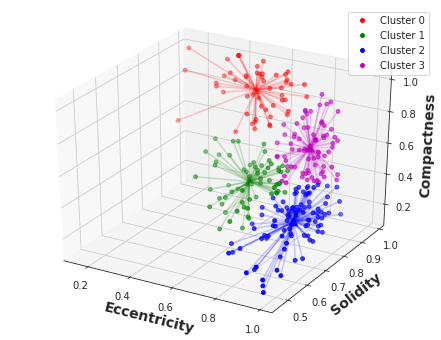

In [153]:
## Plot 3D scatter plot
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(columns.ecc, columns.sol, columns.cmp, c = columns.color, s=15)
ax.scatter(cen_x, cen_y, cen_z, marker='^', c=colors, s=70)
# plot lines
for idx, val in columns.iterrows():
    x = [val.ecc, val.cen_x,]
    y = [val.sol, val.cen_y]
    z = [val.cmp, val.cen_z]
    plt.plot(x, y, z, c=val.color, alpha=0.2)

ax.set_xlabel('Eccentricity',fontweight="bold",fontSize="14",fontname="Avenir")
ax.set_ylabel('Solidity',fontweight="bold",fontSize="14",fontname="Avenir")
ax.set_zlabel('Compactness',fontweight="bold",fontSize="14",fontname="Avenir")

#lcolors = ['g', 'b', 'r','m']
# legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i), 
                   markerfacecolor=mcolor, markersize=6) for i, mcolor in enumerate(colors)]

#plt.legend(handles=legend_elements,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(handles=legend_elements ,loc='best')
plt.grid('off')
#plt.title('Morphological params clustering')
plt.show()

###Box plots with overlayed scatter points for the morphological parameters

#####Eccentricity

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.263e-07 U_stat=7.680e+02
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.586e-25 U_stat=5.600e+01
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.083e-11 U_stat=5.900e+03
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.549e-24 U_stat=1.000e+00
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.535e-19 U_stat=2.430e+02
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:9.138e-22 U_stat=1.100e+01


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


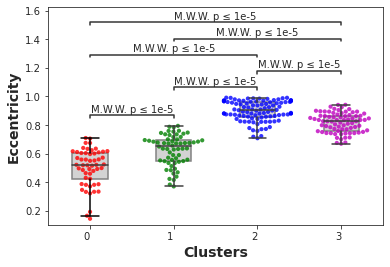

In [154]:
from itertools import combinations
from statannotations.Annotator import Annotator

columns['Cluster_str'] = columns['Cluster']

columns = columns.astype({"Cluster_str": str}, errors='raise') 

clusters = ["0","1","2","3"]
pairs = list(combinations(clusters, r=2))


bplot=sns.boxplot(y = "ecc", x = "Cluster",
                 data=columns,
                 width=.42 , fliersize=0)
annotator = Annotator(bplot, pairs, data=columns, y = "ecc", x = "Cluster_str", order=clusters)
annotator.configure(test="Mann-Whitney", text_format="simple")

annotator.apply_and_annotate()
bplot.set_xticklabels(bplot.get_xticklabels(),horizontalalignment='right') #,rotation=45

# iterate over boxes
for i,box in enumerate(bplot.artists):
    box.set_edgecolor('gray')
    box.set_facecolor('lightgray')

    # iterate over whiskers and median lines
    for j in range(i,(i+1)):
         bplot.lines[j].set_color('black')

sns.swarmplot(y = "ecc", x = "Cluster", zorder=2, size=4.2, 
              data = columns, palette=colors, dodge=True, alpha=0.8)


sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
#sns.despine() #to remove top and right borders
plt.xlabel('Clusters',fontweight="bold",fontSize="14",fontname="Avenir")
plt.ylabel('Eccentricity',fontweight="bold",fontSize="14",fontname="Avenir")
plt.show()

#####Compactness

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.090e-20 U_stat=3.286e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.583e-10 U_stat=4.865e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.768e-29 U_stat=8.000e+00
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.371e-24 U_stat=5.194e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.456e-18 U_stat=3.150e+02
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.397e-16 U_stat=3.741e+03


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


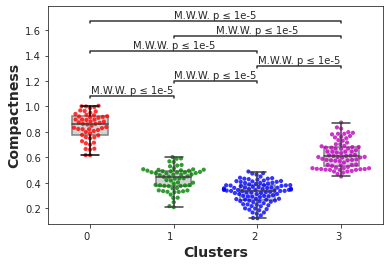

In [155]:

bplot=sns.boxplot(y = "cmp", x = "Cluster",
                 data=columns,
                 width=.42 , fliersize=0)
annotator = Annotator(bplot, pairs, data=columns, y = "cmp", x = "Cluster_str", order=clusters)
annotator.configure(test="Mann-Whitney", text_format="simple")

annotator.apply_and_annotate()
bplot.set_xticklabels(bplot.get_xticklabels(),horizontalalignment='right') #,rotation=45

# iterate over boxes
for i,box in enumerate(bplot.artists):
    box.set_edgecolor('gray')
    box.set_facecolor('lightgray')

    # iterate over whiskers and median lines
    for j in range(i,(i+1)):
         bplot.lines[j].set_color('black')

sns.swarmplot(y = "cmp", x = "Cluster", zorder=2, size=4.2, 
              data = columns, palette=colors, dodge=True, alpha=0.8)


sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
#sns.despine() #to remove top and right borders
plt.xlabel('Clusters',fontweight="bold",fontSize="14",fontname="Avenir")
plt.ylabel('Compactness',fontweight="bold",fontSize="14",fontname="Avenir")
plt.show()

#####Solidity

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.381e-19 U_stat=2.916e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.174e-07 U_stat=3.934e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.176e-26 U_stat=3.130e+02
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.324e-24 U_stat=5.292e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.201e-13 U_stat=5.750e+02
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.492e-14 U_stat=3.972e+03


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


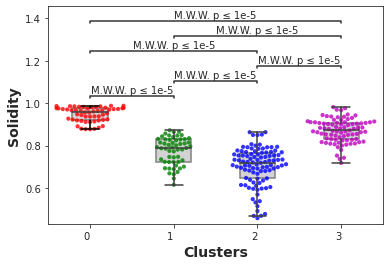

In [108]:
bplot=sns.boxplot(y = "sol", x = "Cluster",
                 data=columns,
                 width=.42 , fliersize=0)
annotator = Annotator(bplot, pairs, data=columns, y = "sol", x = "Cluster_str", order=clusters)
annotator.configure(test="Mann-Whitney", text_format="simple")

annotator.apply_and_annotate()
bplot.set_xticklabels(bplot.get_xticklabels(),horizontalalignment='right') #,rotation=45

# iterate over boxes
for i,box in enumerate(bplot.artists):
    box.set_edgecolor('gray')
    box.set_facecolor('lightgray')

    # iterate over whiskers and median lines
    for j in range(i,(i+1)):
         bplot.lines[j].set_color('black')

sns.swarmplot(y = "sol", x = "Cluster", zorder=2, size=4.2, 
              data = columns, palette=colors, dodge=True, alpha=0.8)


sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
#sns.despine() #to remove top and right borders
plt.xlabel('Clusters',fontweight="bold",fontSize="14",fontname="Avenir")
plt.ylabel('Solidity',fontweight="bold",fontSize="14",fontname="Avenir")
plt.show()

### Motility Plots - Speed and Persistence of the clusters

##### Speed plot using Gaussian Process Regressor model (GPR) predictions

##### Persistence plot using Gaussian Process Regressor model (GPR) predictions